In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.stats import ttest_ind
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
cases = pd.read_csv('ILINet.csv', skiprows=1)
cases.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506


In [ ]:
cases

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,National,X,2023,41,2.29191,2.29444,14308,13873,X,18291,5397,5027,56896,4111,2479729
1359,National,X,2023,42,2.50619,2.49517,15618,14328,X,19997,5779,6128,61850,4096,2478788
1360,National,X,2023,43,2.69580,2.65943,16855,15342,X,22080,6020,6625,66922,4111,2516401
1361,National,X,2023,44,2.96143,2.92928,17570,16397,X,24303,6261,6586,71117,4047,2427801


In [ ]:
cases = cases[['YEAR', 'WEEK', 'ILITOTAL']]
cases

,YEAR,WEEK,ILITOTAL
0,1997,40,570
1,1997,41,615
2,1997,42,681
3,1997,43,653
4,1997,44,700
...,...,...,...
1358,2023,41,56896
1359,2023,42,61850
1360,2023,43,66922
1361,2023,44,71117


In [ ]:
cases_2019_present = cases[cases['YEAR'] >= 2019]
cases_2019_present = cases_2019_present.iloc[39:].reset_index(drop=True)
cases_2019_present

,YEAR,WEEK,ILITOTAL
0,2019,40,21915
1,2019,41,22953
2,2019,42,24857
3,2019,43,27419
4,2019,44,28910
...,...,...,...
210,2023,41,56896
211,2023,42,61850
212,2023,43,66922
213,2023,44,71117


In [ ]:
#cases['date'] = cases.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}', format='%G-%V'), axis=1)
cases['DATE'] = cases.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}-1', format='%G-%V-%u'), axis=1)
cases.set_index('DATE', inplace=True)
cases

,YEAR,WEEK,ILITOTAL
DATE,,,
1997-09-29,1997,40,570
1997-10-06,1997,41,615
1997-10-13,1997,42,681
1997-10-20,1997,43,653
1997-10-27,1997,44,700
...,...,...,...
2023-10-09,2023,41,56896
2023-10-16,2023,42,61850
2023-10-23,2023,43,66922


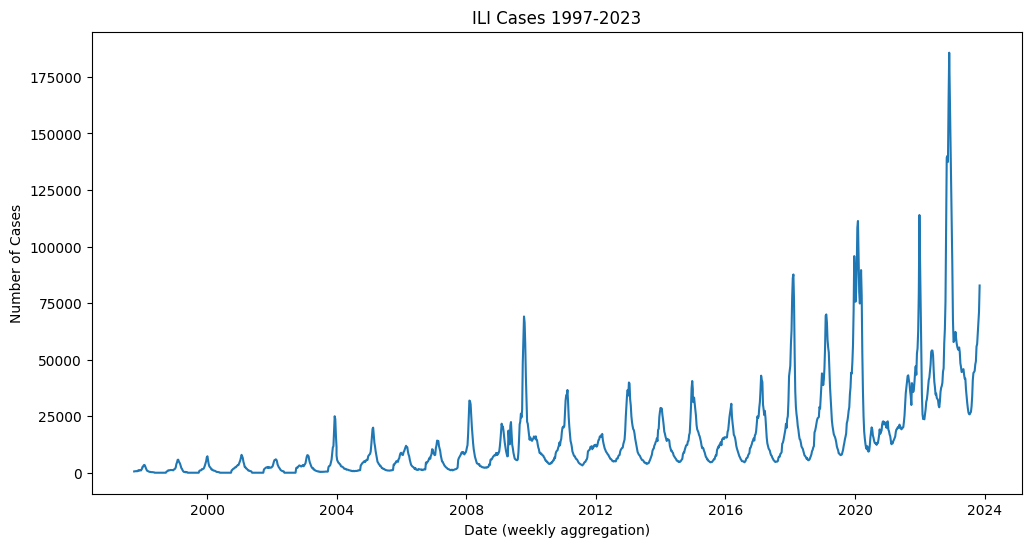

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(cases['ILITOTAL'])
plt.title('ILI Cases 1997-2023')
plt.xlabel('Date (weekly aggregation)')
plt.ylabel('Number of Cases')
plt.show()

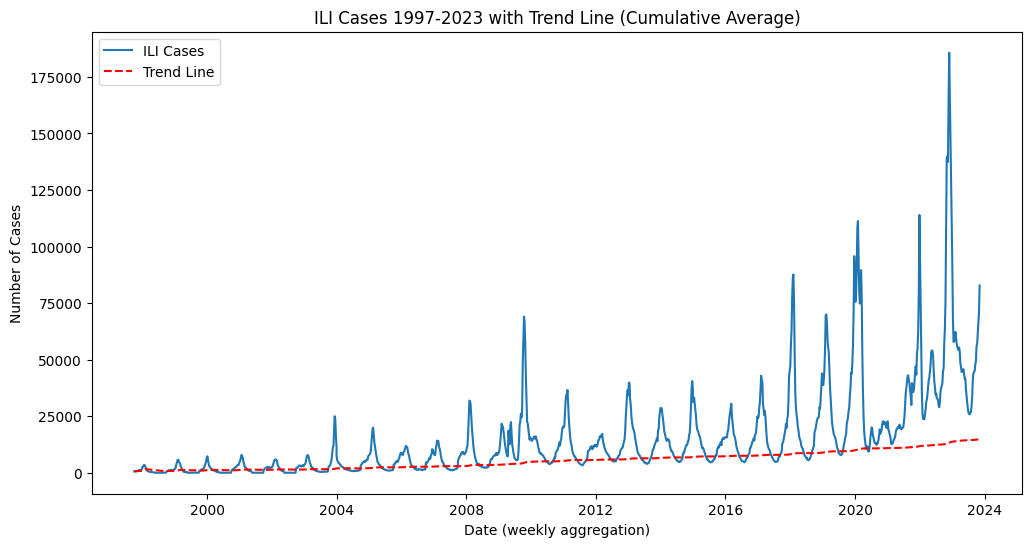

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cases['ILITOTAL'], label='ILI Cases')

# Adding a trend line based on the cumulative average
cumulative_average = cases['ILITOTAL'].expanding().mean()
plt.plot(cumulative_average, label='Trend Line', color='red', linestyle='dashed')

plt.title('ILI Cases 1997-2023 with Trend Line (Cumulative Average)')
plt.xlabel('Date (weekly aggregation)')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

### Decomposition of Time Series

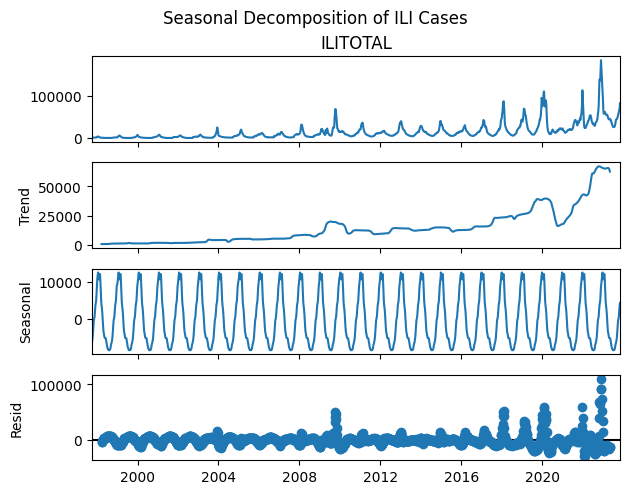

In [ ]:
result = seasonal_decompose(cases['ILITOTAL'], model='additive', period=52)
residuals = result.resid
result.plot()
plt.suptitle('Seasonal Decomposition of ILI Cases', y=1.02)
plt.show()

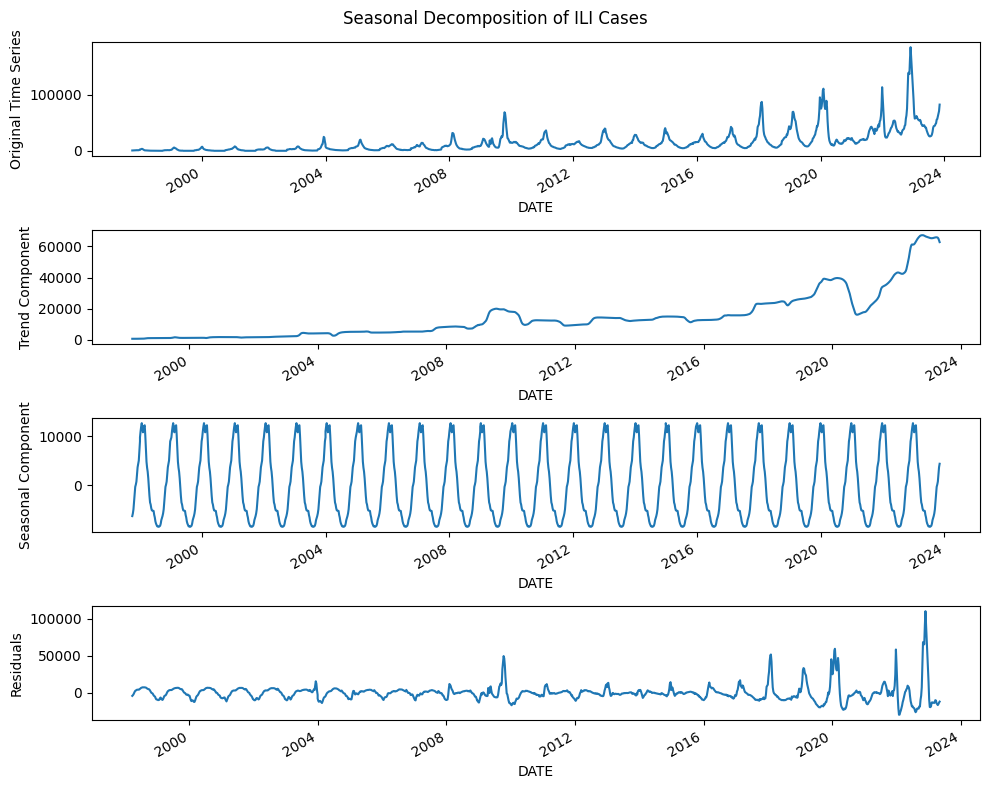

In [ ]:
result = seasonal_decompose(cases['ILITOTAL'], model='additive', period=52)
residuals = result.resid

# Increase the size of the plot by adjusting figsize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Original Time Series')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend Component')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal Component')

residuals.plot(ax=ax4)
ax4.set_ylabel('Residuals')

# Set a title for the entire plot with an adjusted vertical position
plt.suptitle('Seasonal Decomposition of ILI Cases')

plt.tight_layout()
plt.savefig('seasonal_decomposition_plot.png', dpi=300)
plt.show()

In [ ]:
result = adfuller(cases['ILITOTAL'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.231733102998868
p-value: 0.0005819769021666088
Critical Values: {'1%': -3.4352139981780865, '5%': -2.863688081179776, '10%': -2.567913641703717}


### Calculate Anomaly Score

In [ ]:
k=1.5
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
anomalies = (residuals < Q1 - k * IQR) | (residuals > Q3 + k * IQR)

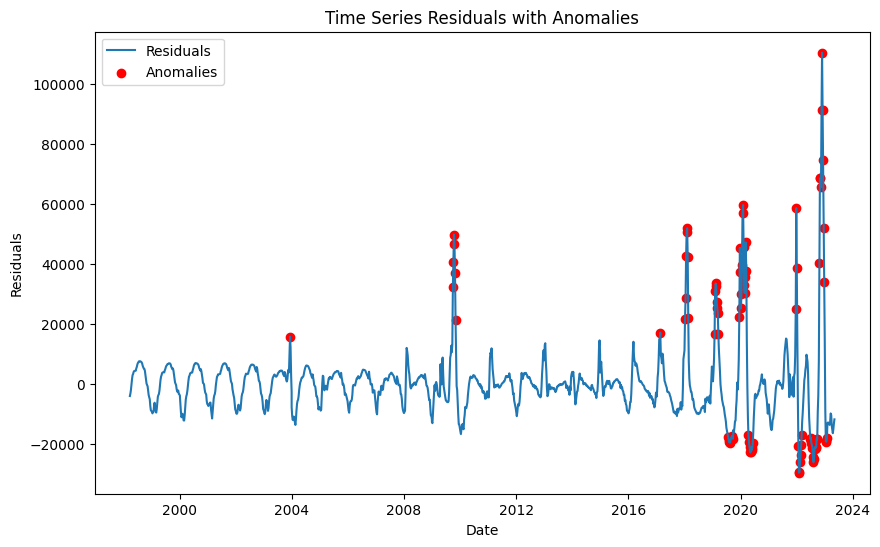

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('Time Series Residuals with Anomalies')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### Repeating all steps on a subset of data (2019-2020 flu season to present)

In [ ]:
# cases_2019_present['DATE'] = cases_2019_present.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}-1', format='%G-%V-%u'), axis=1)
# cases_2019_present['DATE'] = pd.to_datetime(cases_2019_present['DATE'])
# cases_2019_present.set_index('DATE', inplace=True)
# cases_2019_present

In [ ]:
cases_2019_present['DATE'] = cases_2019_present.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}-1', format='%G-%V-%u'), axis=1)
cases_2019_present.set_index('DATE', inplace=True)
cases_2019_present

,YEAR,WEEK,ILITOTAL
DATE,,,
2019-09-30,2019,40,21915
2019-10-07,2019,41,22953
2019-10-14,2019,42,24857
2019-10-21,2019,43,27419
2019-10-28,2019,44,28910
...,...,...,...
2023-10-09,2023,41,56896
2023-10-16,2023,42,61850
2023-10-23,2023,43,66922


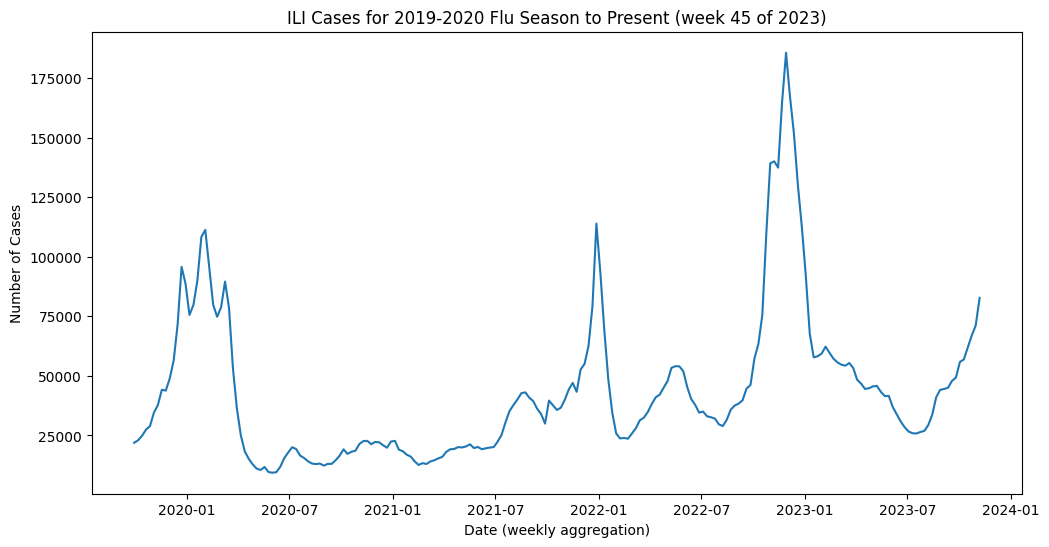

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(cases['ILITOTAL'])
plt.plot(cases_2019_present['ILITOTAL'])
plt.title('ILI Cases for 2019-2020 Flu Season to Present (week 45 of 2023)')
plt.xlabel('Date (weekly aggregation)')
plt.ylabel('Number of Cases')
plt.show()

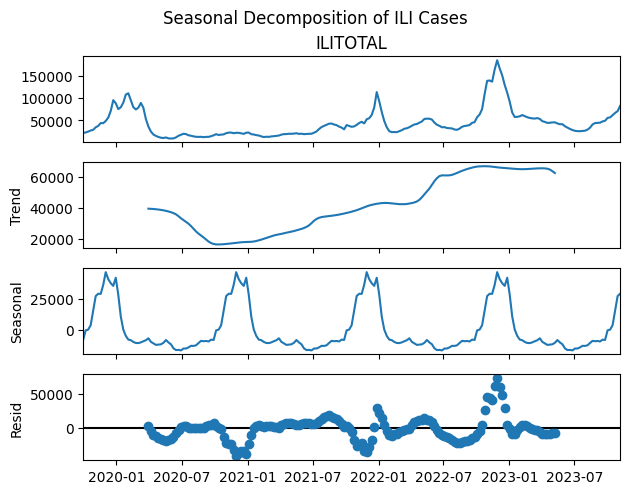

In [ ]:
result = seasonal_decompose(cases_2019_present['ILITOTAL'], model='additive', period=52)
residuals = result.resid
result.plot()
plt.suptitle('Seasonal Decomposition of ILI Cases', y=1.02)
plt.show()

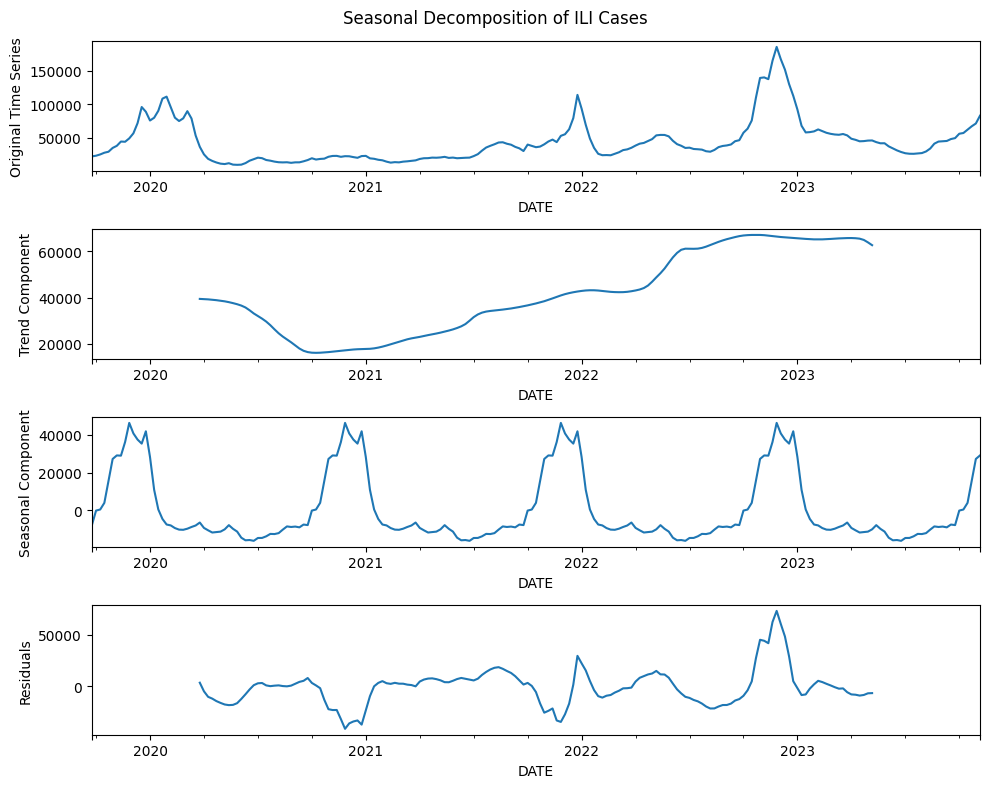

In [ ]:
result = seasonal_decompose(cases_2019_present['ILITOTAL'], model='additive', period=52)
residuals = result.resid

# Increase the size of the plot by adjusting figsize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Original Time Series')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend Component')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal Component')

residuals.plot(ax=ax4)
ax4.set_ylabel('Residuals')

# Set a title for the entire plot with an adjusted vertical position
plt.suptitle('Seasonal Decomposition of ILI Cases')

plt.tight_layout()
plt.savefig('seasonal_decomposition_plot.png', dpi=300)
plt.show()

In [ ]:
result = adfuller(cases_2019_present['ILITOTAL'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.5541416530422927
p-value: 0.0067007464345387
Critical Values: {'1%': -3.461878735881654, '5%': -2.875403665910809, '10%': -2.574159410430839}


In [ ]:
k=1.5
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
anomalies = (residuals < Q1 - k * IQR) | (residuals > Q3 + k * IQR)

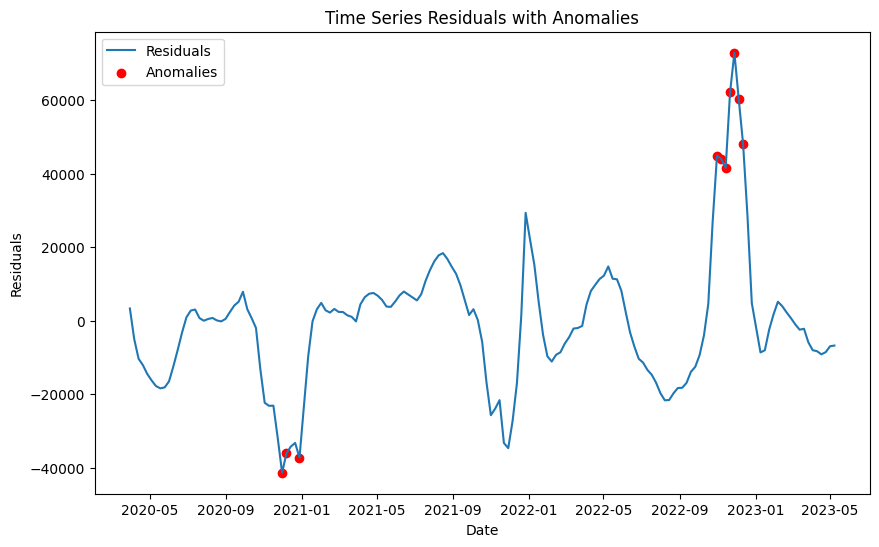

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('Time Series Residuals with Anomalies')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

# Times Series Analysis for Weighted ILI

In [ ]:
cases = pd.read_csv('ILINet.csv', skiprows=1)
cases.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,1997,40,1.10148,1.21686,179,X,157,205,X,29,570,192,46842
1,National,X,1997,41,1.20007,1.28064,199,X,151,242,X,23,615,191,48023
2,National,X,1997,42,1.37876,1.23906,228,X,153,266,X,34,681,219,54961
3,National,X,1997,43,1.19920,1.14473,188,X,193,236,X,36,653,213,57044
4,National,X,1997,44,1.65618,1.26112,217,X,162,280,X,41,700,213,55506


In [ ]:
ili = cases[['YEAR', 'WEEK', '% WEIGHTED ILI']]
ili

,YEAR,WEEK,% WEIGHTED ILI
0,1997,40,1.10148
1,1997,41,1.20007
2,1997,42,1.37876
3,1997,43,1.19920
4,1997,44,1.65618
...,...,...,...
1358,2023,41,2.29191
1359,2023,42,2.50619
1360,2023,43,2.69580
1361,2023,44,2.96143


In [ ]:
ili = ili.loc[ili['WEEK'] != 53]

In [ ]:
ili['DATE'] = ili.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}-1', format='%G-%V-%u'), axis=1)
ili.set_index('DATE', inplace=True)
ili

,YEAR,WEEK,% WEIGHTED ILI
DATE,,,
1997-09-29,1997,40,1.10148
1997-10-06,1997,41,1.20007
1997-10-13,1997,42,1.37876
1997-10-20,1997,43,1.19920
1997-10-27,1997,44,1.65618
...,...,...,...
2023-10-09,2023,41,2.29191
2023-10-16,2023,42,2.50619
2023-10-23,2023,43,2.69580


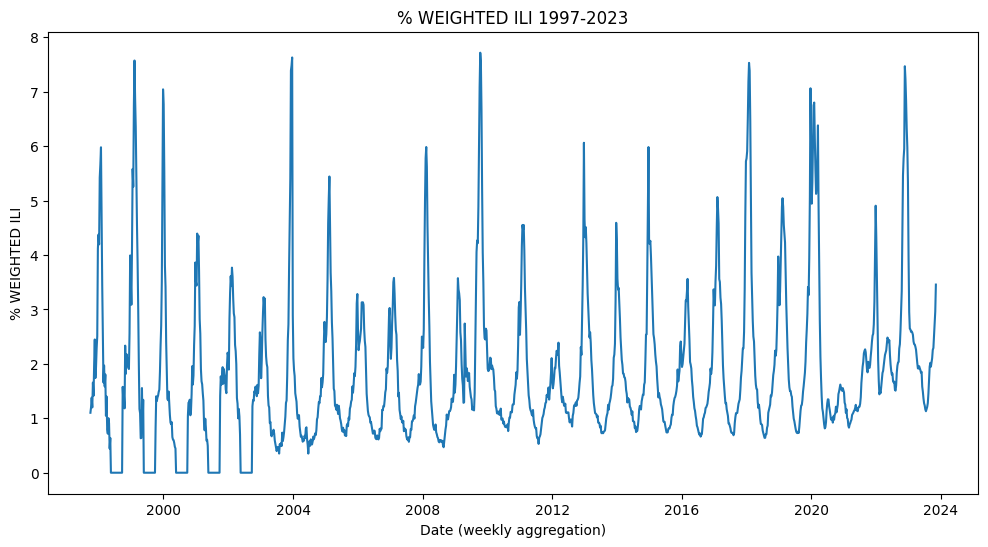

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(ili['% WEIGHTED ILI'])
plt.title('% WEIGHTED ILI 1997-2023')
plt.xlabel('Date (weekly aggregation)')
plt.ylabel('% WEIGHTED ILI')
plt.show()

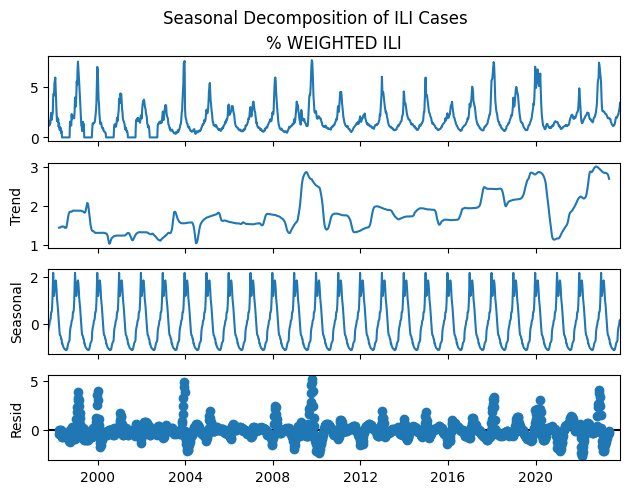

In [ ]:
result = seasonal_decompose(ili['% WEIGHTED ILI'], model='additive', period=52)
residuals = result.resid
result.plot()
plt.suptitle('Seasonal Decomposition of ILI Cases', y=1.02)
plt.show()

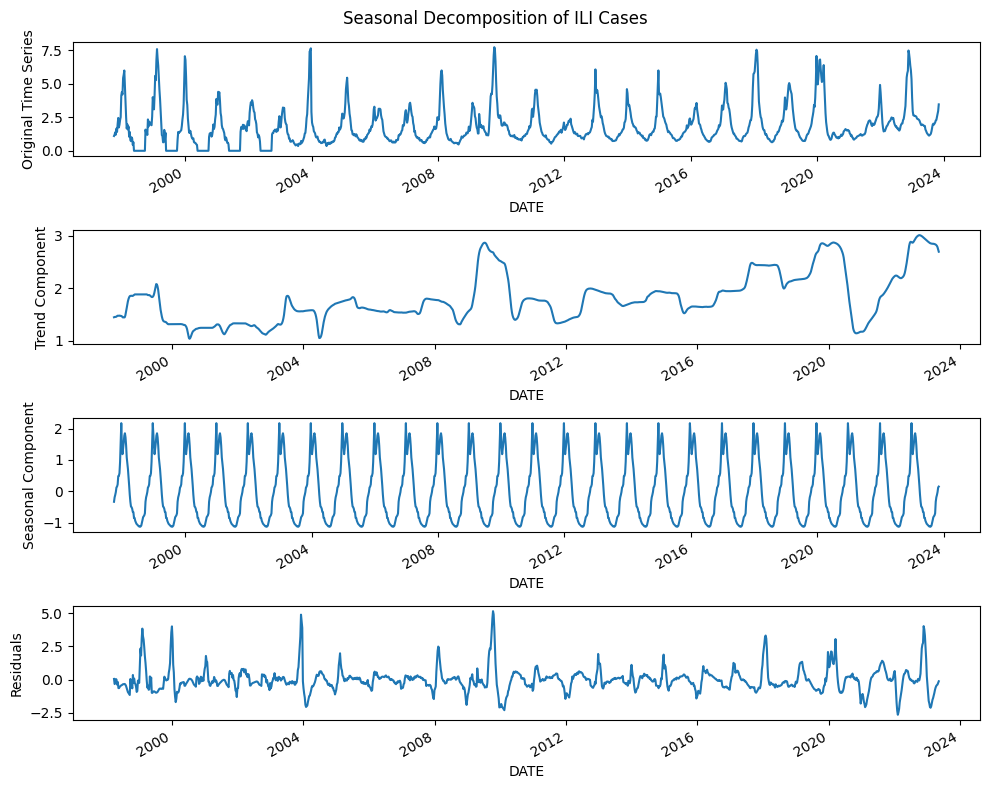

In [ ]:
result = seasonal_decompose(ili['% WEIGHTED ILI'], model='additive', period=52)
residuals = result.resid

# Increase the size of the plot by adjusting figsize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

result.observed.plot(ax=ax1)
ax1.set_ylabel('Original Time Series')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend Component')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal Component')

residuals.plot(ax=ax4)
ax4.set_ylabel('Residuals')

# Set a title for the entire plot with an adjusted vertical position
plt.suptitle('Seasonal Decomposition of ILI Cases')

plt.tight_layout()
plt.savefig('seasonal_decomposition_plot.png', dpi=300)
plt.show()

In [ ]:
result = adfuller(ili['% WEIGHTED ILI'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.382010475158355
p-value: 6.916751070626713e-16
Critical Values: {'1%': -3.4352578040092436, '5%': -2.863707411237363, '10%': -2.5679239356703}


In [ ]:
k=1.5
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
anomalies = (residuals < Q1 - k * IQR) | (residuals > Q3 + k * IQR)

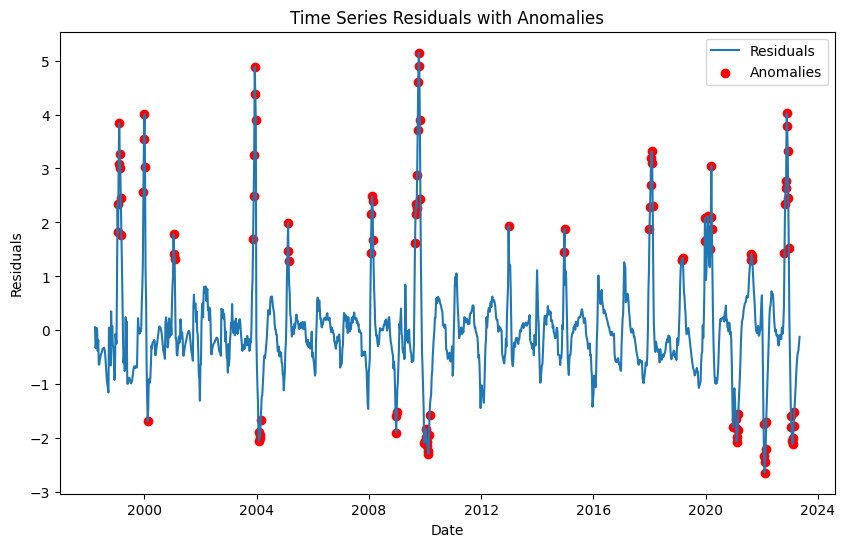

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('Time Series Residuals with Anomalies')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
ili_2019_present = ili[ili['YEAR'] >= 2019]
ili_2019_present = ili_2019_present.iloc[39:].reset_index(drop=True)
ili_2019_present

,YEAR,WEEK,% WEIGHTED ILI
0,2019,40,1.49064
1,2019,41,1.59269
2,2019,42,1.72517
3,2019,43,1.83428
4,2019,44,2.04049
...,...,...,...
209,2023,41,2.29191
210,2023,42,2.50619
211,2023,43,2.69580
212,2023,44,2.96143


In [ ]:
ili_2019_present['DATE'] = ili_2019_present.apply(lambda row: pd.to_datetime(f'{int(row["YEAR"])}-{int(row["WEEK"])}-1', format='%G-%V-%u'), axis=1)
ili_2019_present.set_index('DATE', inplace=True)
ili_2019_present

,YEAR,WEEK,% WEIGHTED ILI
DATE,,,
2019-09-30,2019,40,1.49064
2019-10-07,2019,41,1.59269
2019-10-14,2019,42,1.72517
2019-10-21,2019,43,1.83428
2019-10-28,2019,44,2.04049
...,...,...,...
2023-10-09,2023,41,2.29191
2023-10-16,2023,42,2.50619
2023-10-23,2023,43,2.69580


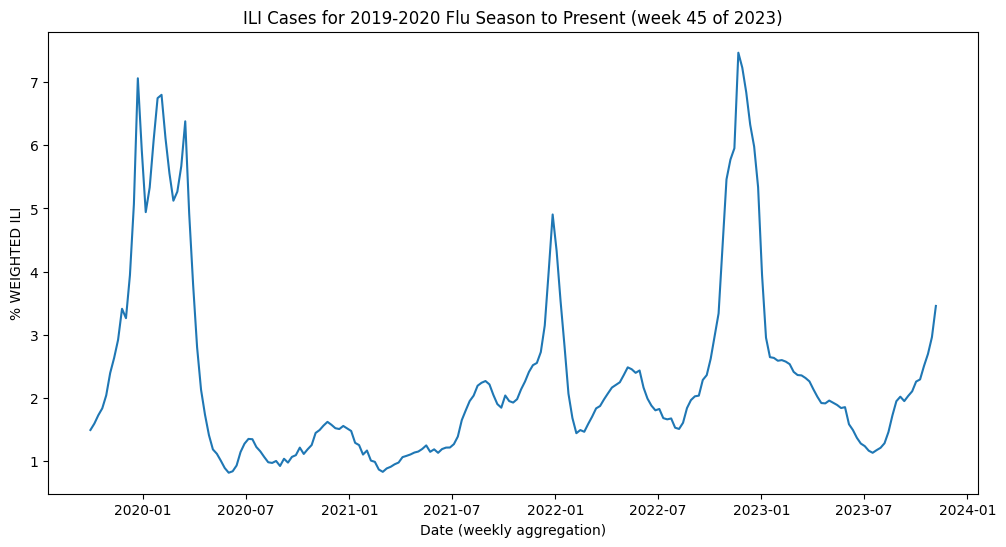

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(cases['ILITOTAL'])
plt.plot(ili_2019_present['% WEIGHTED ILI'])
plt.title('ILI Cases for 2019-2020 Flu Season to Present (week 45 of 2023)')
plt.xlabel('Date (weekly aggregation)')
plt.ylabel('% WEIGHTED ILI')
plt.show()

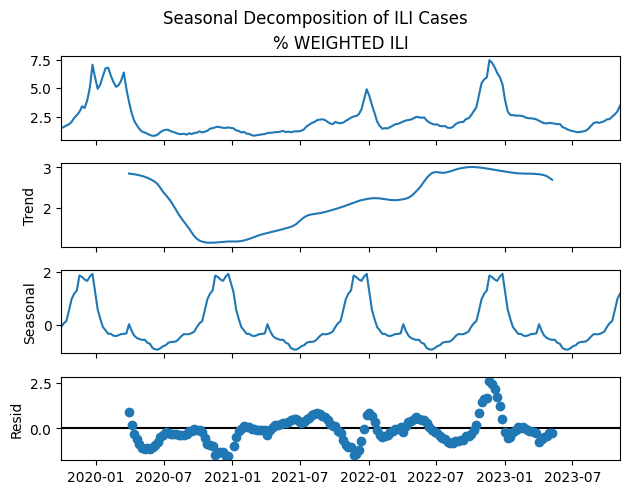

In [ ]:
result = seasonal_decompose(ili_2019_present['% WEIGHTED ILI'], model='additive', period=52)
residuals = result.resid
result.plot()
plt.suptitle('Seasonal Decomposition of ILI Cases', y=1.02)
plt.show()

In [ ]:
result = adfuller(ili_2019_present['% WEIGHTED ILI'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.226178376924156
p-value: 0.01851850605568578
Critical Values: {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}


In [ ]:
k=1.5
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
anomalies = (residuals < Q1 - k * IQR) | (residuals > Q3 + k * IQR)

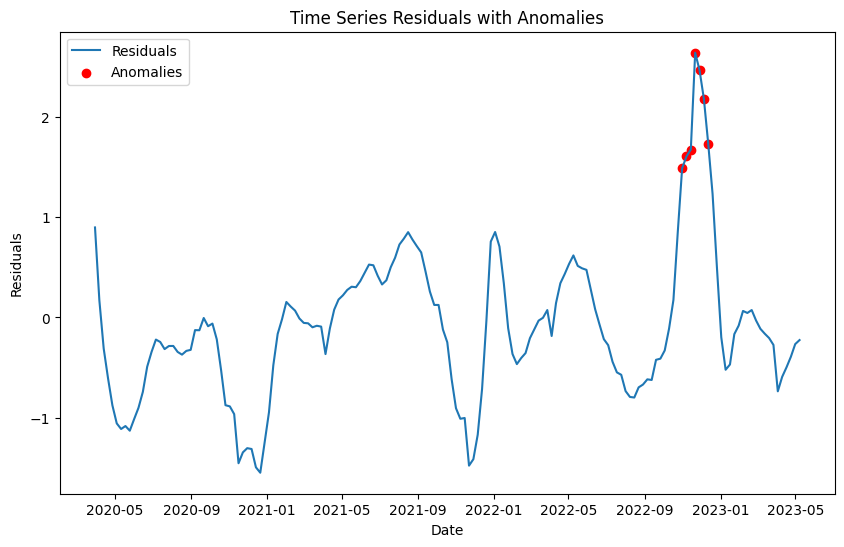

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('Time Series Residuals with Anomalies')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7e7b740-ad7d-41a8-9704-cb0c6a8385eb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>